# Project Introduction:

Welcome to this Jupyter Notebook showcasing the collaborative efforts of Team PyCoders in the project "Collaborative and Hybrid Recommender System for Enhanced Movie Recommendations" 

Our team consists of: 
- Neelesh Vashist (C0858518)
- Rohit Kumar (C0859060)
- Mukul Bisht (C0857928)
- Saurabh Singh (C0859334)

In this notebook, we delve into the fascinating world of recommendation systems, where we demonstrate how collaborative filtering and sentiment analysis can be harnessed to provide users with tailored movie suggestions that cater to both their preferences and emotions.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

from textblob import TextBlob

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD

import matplotlib.pyplot as plt


## Data Loading

In [2]:
# Load the MovieLens dataset
ratings = pd.read_csv('files/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# Load the movie information dataset
movie_info = pd.read_csv('files/u.item', sep='|', encoding='latin-1', header=None,
                         names=['item_id', 'movie title', 'release date', 'video release date', 'IMDb URL',
                                'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
                                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Load the movie data
# Define the columns for movie data
columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action',
           'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies_data = pd.read_csv('files/u.item', sep='|', names=columns, encoding='latin-1')

# Load YouTube comments data
youtube_comments = pd.read_csv('files/youtube_comments.csv')

# Load the movies_with_youtube_ids DataFrame
movies_with_youtube_ids = pd.read_csv('files/movies_with_youtube_ids.csv')

# Merge YouTube sentiment data with movies data
movies_with_youtube_sentiment = movies_with_youtube_ids.merge(youtube_comments, left_on='youtube_video_id', right_on='youtube_video_id', how='left')

# Load ratings data from ratings.csv file
ratings_df = pd.read_csv('files/ratings.csv')

In [3]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movie_info.head()

,item_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
movies_data.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
youtube_comments.head()

,youtube_video_id,comment_text
0,v-PjgYDrg70,Hooo
1,lcOqUE0u1LM,"Merveilleux film, je l'ai vu depuis des année..."
2,0hu12MP7b1U,Its a perfect film.
3,t2QcA-KoF5s,Kevin Spacey - winning Oscar Best Actor for th...
4,5Pp64srMAH4,Just finished it and i said to myself after se...


In [7]:
movies_with_youtube_ids.head()

,movie_id,movie_title,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,youtube_video_id
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,v-PjgYDrg70
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,lcOqUE0u1LM
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0hu12MP7b1U
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,t2QcA-KoF5s
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,5Pp64srMAH4


In [8]:
movies_with_youtube_sentiment.head()

,movie_id,movie_title,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,youtube_video_id,comment_text
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,v-PjgYDrg70,Hooo
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,lcOqUE0u1LM,"Merveilleux film, je l'ai vu depuis des année..."
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0hu12MP7b1U,Its a perfect film.
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,t2QcA-KoF5s,Kevin Spacey - winning Oscar Best Actor for th...
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,5Pp64srMAH4,Just finished it and i said to myself after se...


In [9]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [10]:
# Create the user-item rating matrix
user_item_matrix = ratings.pivot_table(index='user_id', columns='item_id', values='rating')

# Fill missing values with 0 (user hasn't rated the movie)
user_item_matrix = user_item_matrix.fillna(0)

## Collaborative Recommendation System

In [11]:
# Convert the user-item matrix to a sparse matrix
user_item_sparse = csr_matrix(user_item_matrix.values)

# Calculate the user similarity matrix
user_similarity = pairwise_distances(user_item_sparse, metric='cosine')

# Perform matrix factorization using SVD
U, sigma, Vt = svds(user_item_sparse, k=50)
sigma = np.diag(sigma)

# Predict ratings for all users
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert predicted ratings to a DataFrame
predicted_ratings_df = pd.DataFrame(predicted_ratings, columns=user_item_matrix.columns)


In [12]:
# Flatten the user-item rating matrix and predicted ratings matrix
actual_ratings_flatten = user_item_matrix.values.flatten()
predicted_ratings_flatten = predicted_ratings_df.values.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings_flatten, predicted_ratings_flatten))
print(f"RMSE for Collaborative Filtering: {rmse:.4f}")


RMSE for Collaborative Filtering: 0.5800


## Findings from Collaborative Filtering

In [13]:
# Function to get top N movies with highest predicted ratings for all users
def get_top_movies_for_users(predicted_ratings_df, n=10):
    top_movies_for_users = {}
    for user_id in predicted_ratings_df.index:
        top_movies = predicted_ratings_df.loc[user_id].sort_values(ascending=False).index[:n]
        top_movies_for_users[user_id] = top_movies
    return top_movies_for_users

# Get top 10 movies with highest predicted ratings for all users
top_movies_for_users = get_top_movies_for_users(predicted_ratings_df)


### Top 10 movie titles for each user

In [14]:
# Create a dictionary to map item IDs to movie titles
item_id_to_title = dict(zip(movie_info['item_id'], movie_info['movie title']))

# Display top 10 movie titles for each user
for user_id, top_movies in top_movies_for_users.items():
    top_movie_titles = [item_id_to_title[item_id] for item_id in top_movies]
    print(f"User {user_id}: {top_movie_titles}")


User 0: ['Fargo (1996)', 'Blade Runner (1982)', 'Aliens (1986)', 'Toy Story (1995)', 'Usual Suspects, The (1995)', 'Chasing Amy (1997)', 'Alien (1979)', 'Star Wars (1977)', '2001: A Space Odyssey (1968)', 'Full Monty, The (1997)']
User 1: ['English Patient, The (1996)', 'Full Monty, The (1997)', 'Godfather, The (1972)', 'L.A. Confidential (1997)', 'Fargo (1996)', 'Titanic (1997)', 'Sense and Sensibility (1995)', 'Star Wars (1977)', 'Secrets & Lies (1996)', 'Men in Black (1997)']
User 2: ['Chasing Amy (1997)', 'Boogie Nights (1997)', 'Game, The (1997)', 'L.A. Confidential (1997)', 'Air Force One (1997)', 'Conspiracy Theory (1997)', 'Cop Land (1997)', 'Scream (1996)', 'Starship Troopers (1997)', "Devil's Advocate, The (1997)"]
User 3: ['Contact (1997)', 'Scream (1996)', 'Air Force One (1997)', 'Liar Liar (1997)', 'Star Wars (1977)', 'Conspiracy Theory (1997)', 'Return of the Jedi (1983)', 'Saint, The (1997)', 'In & Out (1997)', 'L.A. Confidential (1997)']
User 4: ['Monty Python and the H

### Top 10 Movies with Highest Predicted Ratings

In [15]:
# Get the mean predicted rating for each movie
mean_predicted_ratings = predicted_ratings_df.mean()

# Get the top 10 movies with highest mean predicted ratings
top_rated_movies = mean_predicted_ratings.sort_values(ascending=False).index[:10]
top_rated_movie_titles = [item_id_to_title[item_id] for item_id in top_rated_movies]

# Print the top 10 movies with highest mean predicted ratings along with their ratings
print("Top 10 Movies with Highest Predicted Ratings:")
for idx, (movie_title, rating) in enumerate(zip(top_rated_movie_titles, mean_predicted_ratings[top_rated_movies]), start=1):
    print(f"{idx}. {movie_title}: {rating:.2f}")


Top 10 Movies with Highest Predicted Ratings:
1. Star Wars (1977): 2.69
2. Fargo (1996): 2.21
3. Return of the Jedi (1983): 2.17
4. Contact (1997): 2.03
5. Raiders of the Lost Ark (1981): 1.89
6. Godfather, The (1972): 1.87
7. Toy Story (1995): 1.86
8. English Patient, The (1996): 1.85
9. Silence of the Lambs, The (1991): 1.78
10. Scream (1996): 1.71


### Top 10 Recommended Movies for User

In [16]:
# Specify a valid user ID for recommendation (replace with an existing user ID)
user_id_for_recommendation = 1  # Replace with an existing user ID

# Rest of the code remains the same
user_rated_movies = user_item_matrix.loc[user_id_for_recommendation]
unrated_movies = user_rated_movies[user_rated_movies == 0].index

predicted_ratings_for_user = predicted_ratings_df.loc[user_id_for_recommendation]
predicted_ratings_for_unrated = predicted_ratings_for_user[unrated_movies]

top_recommended_movies = predicted_ratings_for_unrated.sort_values(ascending=False).index[:10]
top_recommended_movie_titles = [item_id_to_title[item_id] for item_id in top_recommended_movies]

# Print the top 10 recommended movies for the user along with their ratings
print("\nTop 10 Recommended Movies for User (User 1 in this case):")
for idx, (movie_title, rating) in enumerate(zip(top_recommended_movie_titles, predicted_ratings_for_unrated[top_recommended_movies]), start=1):
    print(f"{idx}. {movie_title}: {rating:.2f}")



Top 10 Recommended Movies for User (User 1 in this case):
1. English Patient, The (1996): 5.88
2. L.A. Confidential (1997): 4.20
3. Titanic (1997): 4.02
4. Sense and Sensibility (1995): 3.99
5. Secrets & Lies (1996): 3.55
6. In & Out (1997): 2.94
7. Evita (1996): 2.86
8. Emma (1996): 2.73
9. Apt Pupil (1998): 2.68
10. Air Force One (1997): 2.56


### 10 Least Recommended Movies

In [17]:
# Get the bottom 10 movies with lowest mean predicted ratings
least_rated_movies = mean_predicted_ratings.sort_values(ascending=True).index[:10]
least_rated_movie_titles = [item_id_to_title[item_id] for item_id in least_rated_movies]

# Print the 10 least recommended movies along with their ratings
print("\n10 Least Recommended Movies:")
for idx, (movie_title, rating) in enumerate(zip(least_rated_movie_titles, mean_predicted_ratings[least_rated_movies]), start=1):
    print(f"{idx}. {movie_title}: {rating:.2f}")



10 Least Recommended Movies:
1. Very Natural Thing, A (1974): 0.00
2. War at Home, The (1996): 0.00
3. Sunchaser, The (1996): 0.00
4. King of New York (1990): 0.00
5. Office Killer (1997): 0.00
6. Walk in the Sun, A (1945): 0.00
7. Careful (1992): 0.00
8. Vermont Is For Lovers (1992): 0.00
9. Vie est belle, La (Life is Rosey) (1987): 0.00
10. Quartier Mozart (1992): 0.00


## Visualization for Collaborative Recommender System

### Top 10 Movies with Highest Predicted Rating

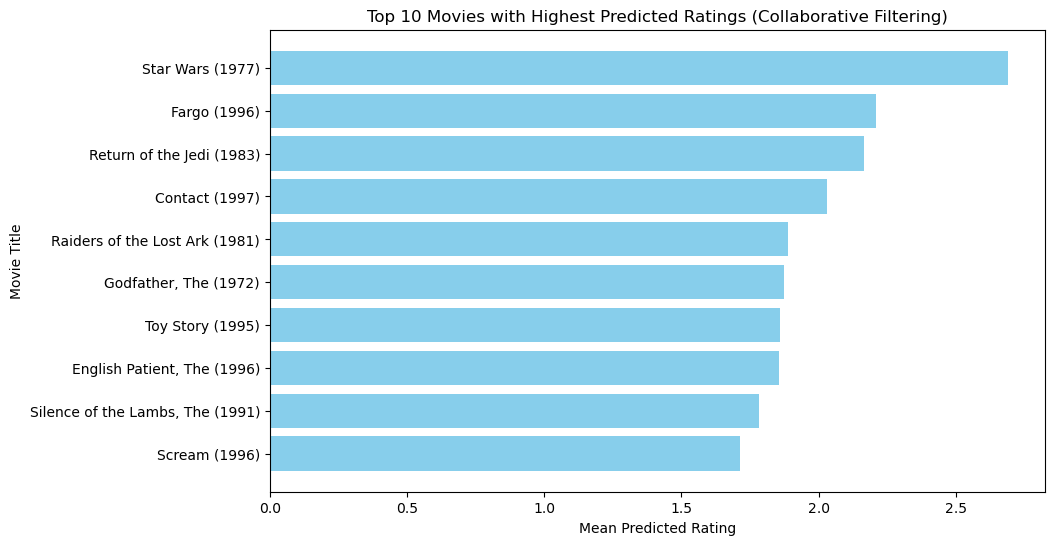

In [18]:
# Get the top 10 movies with highest mean predicted ratings
top_rated_movies = mean_predicted_ratings.sort_values(ascending=False).index[:10]
top_rated_movie_titles = [item_id_to_title[item_id] for item_id in top_rated_movies]
top_rated_movie_scores = [mean_predicted_ratings[item_id] for item_id in top_rated_movies]

plt.figure(figsize=(10, 6))
plt.barh(top_rated_movie_titles, top_rated_movie_scores, color='skyblue')
plt.xlabel('Mean Predicted Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies with Highest Predicted Ratings (Collaborative Filtering)')
plt.gca().invert_yaxis()
plt.show()


### 10 Least Recommended Movies

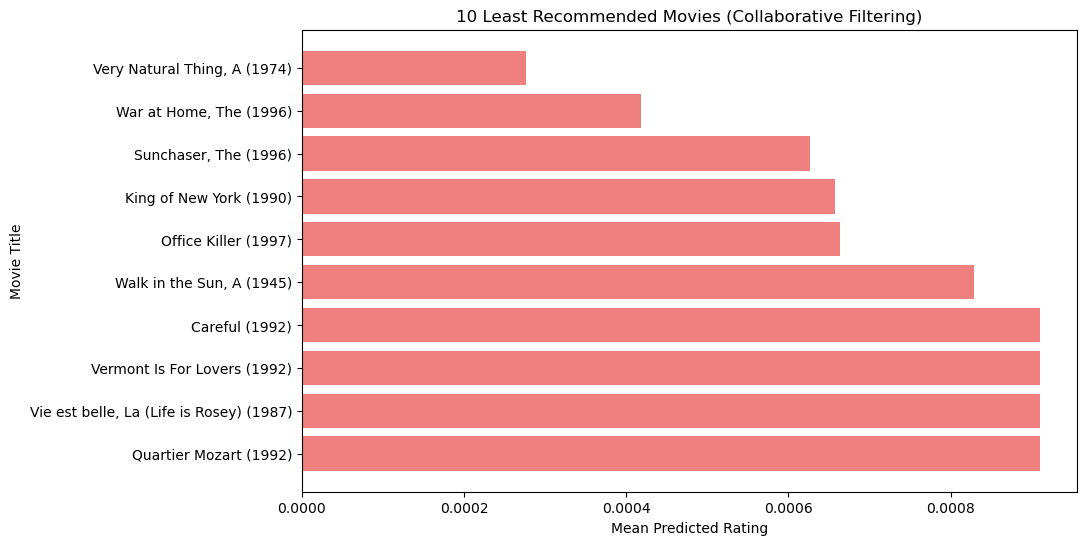

In [19]:
# Get the bottom 10 movies with lowest mean predicted ratings
least_rated_movies = mean_predicted_ratings.sort_values(ascending=True).index[:10]
least_rated_movie_titles = [item_id_to_title[item_id] for item_id in least_rated_movies]
least_rated_movie_scores = [mean_predicted_ratings[item_id] for item_id in least_rated_movies]

plt.figure(figsize=(10, 6))
plt.barh(least_rated_movie_titles, least_rated_movie_scores, color='lightcoral')
plt.xlabel('Mean Predicted Rating')
plt.ylabel('Movie Title')
plt.title('10 Least Recommended Movies (Collaborative Filtering)')
plt.gca().invert_yaxis()
plt.show()


# Hybrid Recommender System

## Sentiment Analysis using TextBlob

In [20]:
def calculate_sentiment_score(comment):
    analysis = TextBlob(comment)
    return analysis.sentiment.polarity

youtube_comments['sentiment_score'] = youtube_comments['comment_text'].apply(calculate_sentiment_score)

movies_with_youtube_sentiment['sentiment_score'] = movies_with_youtube_sentiment['comment_text'].apply(calculate_sentiment_score)


In [21]:
# Normalize sentiment scores
scaler = MinMaxScaler()
movies_with_youtube_sentiment['normalized_sentiment_score'] = scaler.fit_transform(movies_with_youtube_sentiment[['sentiment_score']].fillna(0))

# Print the updated DataFrame
print(movies_with_youtube_sentiment)


      movie_id                                movie_title  unknown  Action  \
0            1                           Toy Story (1995)        0       0   
1            2                           GoldenEye (1995)        0       1   
2            3                          Four Rooms (1995)        0       0   
3            4                          Get Shorty (1995)        0       1   
4            5                             Copycat (1995)        0       0   
...        ...                                        ...      ...     ...   
1845      1679                           B. Monkey (1998)        0       0   
1846      1680                       Sliding Doors (1998)        0       0   
1847      1680                       Sliding Doors (1998)        0       0   
1848      1681                        You So Crazy (1994)        0       0   
1849      1682  Scream of Stone (Schrei aus Stein) (1991)        0       0   

      Adventure  Animation  Children  Comedy  Crime  Documentar

In [22]:
movies_with_youtube_sentiment.head()

,movie_id,movie_title,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,youtube_video_id,comment_text,sentiment_score,normalized_sentiment_score
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,v-PjgYDrg70,Hooo,0.000000,0.500000
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,lcOqUE0u1LM,"Merveilleux film, je l'ai vu depuis des année...",0.000000,0.500000
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0hu12MP7b1U,Its a perfect film.,1.000000,1.000000
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,t2QcA-KoF5s,Kevin Spacey - winning Oscar Best Actor for th...,0.750000,0.875000
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,5Pp64srMAH4,Just finished it and i said to myself after se...,0.308333,0.654167


In [42]:
desired_columns = ['movie_id', 'movie_title', 'youtube_video_id', 'normalized_sentiment_score']

# Create a new DataFrame with the desired columns
selected_df = movies_with_youtube_sentiment[desired_columns]

# Print the resulting DataFrame
selected_df.head()

,movie_id,movie_title,youtube_video_id,normalized_sentiment_score
0,1,Toy Story (1995),v-PjgYDrg70,0.500000
1,2,GoldenEye (1995),lcOqUE0u1LM,0.500000
2,3,Four Rooms (1995),0hu12MP7b1U,1.000000
3,4,Get Shorty (1995),t2QcA-KoF5s,0.875000
4,5,Copycat (1995),5Pp64srMAH4,0.654167


## Colab Predictions

In [23]:
# Load ratings data from ratings.csv file
ratings_df = pd.read_csv('files/ratings.csv')# Load data into Surprise's Dataset format
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Build and train the collaborative filtering model (using SVD algorithm)
model = SVD()
model.fit(trainset)

# Get predictions for the test set
collab_predictions = model.test(testset)

# Print the first few predictions
for prediction in collab_predictions[:5]:
    print(prediction)


user: 28943      item: 96079      r_ui = 4.00   est = 3.69   {'was_impossible': False}
user: 130375     item: 158813     r_ui = 2.50   est = 2.73   {'was_impossible': False}
user: 320709     item: 7981       r_ui = 3.50   est = 3.44   {'was_impossible': False}
user: 35437      item: 838        r_ui = 5.00   est = 3.66   {'was_impossible': False}
user: 252123     item: 267        r_ui = 1.00   est = 3.82   {'was_impossible': False}


## Hybrid scores for every movie

In [24]:
# Define the hybrid recommendation function
def hybrid_recommendation(user_id, movie_id, collab_predictions, movies_df):
    collab_pred = None
    for prediction in collab_predictions:
        if prediction.uid == user_id and prediction.iid == movie_id:
            collab_pred = prediction.est
            break
    if collab_pred is None:
        collab_pred = 0.0  # Default prediction if no collaborative prediction available
    
    sentiment_score = movies_df.loc[movies_df['movie_id'] == movie_id, 'normalized_sentiment_score'].values[0]
    hybrid_score = 0.7 * collab_pred + 0.3 * sentiment_score  # Adjust weights as needed
    return hybrid_score

# Calculate hybrid scores for every movie in movies_with_youtube_sentiment
hybrid_scores = []
for index, row in movies_with_youtube_sentiment.iterrows():
    movie_id = row['movie_id']
    movie_title = row['movie_title']
    hybrid_score = hybrid_recommendation(1, movie_id, collab_predictions, movies_with_youtube_sentiment)
    hybrid_scores.append((movie_id, movie_title, hybrid_score))
    print(f"Hybrid Score for movie '{movie_title}' (movie id {movie_id}): {hybrid_score}")

# Print hybrid scores
for i, score in enumerate(hybrid_scores):
    print(f"Hybrid Score for movie {movies_with_youtube_sentiment['movie_id'][i]}: {score}")

Hybrid Score for movie 'Toy Story (1995)' (movie id 1): 0.15
Hybrid Score for movie 'GoldenEye (1995)' (movie id 2): 0.15
Hybrid Score for movie 'Four Rooms (1995)' (movie id 3): 0.3
Hybrid Score for movie 'Get Shorty (1995)' (movie id 4): 0.2625
Hybrid Score for movie 'Copycat (1995)' (movie id 5): 0.19625
Hybrid Score for movie 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)' (movie id 6): 0.15
Hybrid Score for movie 'Twelve Monkeys (1995)' (movie id 7): 0.15
Hybrid Score for movie 'Babe (1995)' (movie id 8): 0.1425
Hybrid Score for movie 'Dead Man Walking (1995)' (movie id 9): 0.18
Hybrid Score for movie 'Richard III (1995)' (movie id 10): 0.3
Hybrid Score for movie 'Seven (Se7en) (1995)' (movie id 11): 0.1809047619047619
Hybrid Score for movie 'Usual Suspects, The (1995)' (movie id 12): 0.15
Hybrid Score for movie 'Mighty Aphrodite (1995)' (movie id 13): 0.15
Hybrid Score for movie 'Postino, Il (1994)' (movie id 14): 0.15
Hybrid Score for movie 'Mr. Holland's Opus (1995)' (mo

Hybrid Score for movie 'Diabolique (1996)' (movie id 106): 0.15
Hybrid Score for movie 'Diabolique (1996)' (movie id 106): 0.15
Hybrid Score for movie 'Diabolique (1996)' (movie id 106): 0.15
Hybrid Score for movie 'Diabolique (1996)' (movie id 106): 0.15
Hybrid Score for movie 'Moll Flanders (1996)' (movie id 107): 0.15
Hybrid Score for movie 'Kids in the Hall: Brain Candy (1996)' (movie id 108): 0.15
Hybrid Score for movie 'Mystery Science Theater 3000: The Movie (1996)' (movie id 109): 0.15
Hybrid Score for movie 'Operation Dumbo Drop (1995)' (movie id 110): 0.18
Hybrid Score for movie 'Truth About Cats & Dogs, The (1996)' (movie id 111): 0.165
Hybrid Score for movie 'Flipper (1996)' (movie id 112): 0.15
Hybrid Score for movie 'Horseman on the Roof, The (Hussard sur le toit, Le) (1995)' (movie id 113): 0.15
Hybrid Score for movie 'Wallace & Gromit: The Best of Aardman Animation (1996)' (movie id 114): 0.22499999999999998
Hybrid Score for movie 'Haunted World of Edward D. Wood Jr., T

Hybrid Score for movie 'This Is Spinal Tap (1984)' (movie id 209): 0.15
Hybrid Score for movie 'This Is Spinal Tap (1984)' (movie id 209): 0.15
Hybrid Score for movie 'This Is Spinal Tap (1984)' (movie id 209): 0.15
Hybrid Score for movie 'This Is Spinal Tap (1984)' (movie id 209): 0.15
Hybrid Score for movie 'This Is Spinal Tap (1984)' (movie id 209): 0.15
Hybrid Score for movie 'This Is Spinal Tap (1984)' (movie id 209): 0.15
Hybrid Score for movie 'This Is Spinal Tap (1984)' (movie id 209): 0.15
Hybrid Score for movie 'This Is Spinal Tap (1984)' (movie id 209): 0.15
Hybrid Score for movie 'Indiana Jones and the Last Crusade (1989)' (movie id 210): 0.3
Hybrid Score for movie 'M*A*S*H (1970)' (movie id 211): 0.1875
Hybrid Score for movie 'Unbearable Lightness of Being, The (1988)' (movie id 212): 0.15
Hybrid Score for movie 'Room with a View, A (1986)' (movie id 213): 0.15
Hybrid Score for movie 'Pink Floyd - The Wall (1982)' (movie id 214): 0.15
Hybrid Score for movie 'Field of Dream

Hybrid Score for movie 'Devil's Advocate, The (1997)' (movie id 307): 0.1875
Hybrid Score for movie 'FairyTale: A True Story (1997)' (movie id 308): 0.0705
Hybrid Score for movie 'Deceiver (1997)' (movie id 309): 0.17045454545454544
Hybrid Score for movie 'Deceiver (1997)' (movie id 309): 0.17045454545454544
Hybrid Score for movie 'Rainmaker, The (1997)' (movie id 310): 0.17500000000000002
Hybrid Score for movie 'Wings of the Dove, The (1997)' (movie id 311): 0.15
Hybrid Score for movie 'Midnight in the Garden of Good and Evil (1997)' (movie id 312): 0.22499999999999998
Hybrid Score for movie 'Titanic (1997)' (movie id 313): 0.0825
Hybrid Score for movie '3 Ninjas: High Noon At Mega Mountain (1998)' (movie id 314): 0.13125
Hybrid Score for movie 'Apt Pupil (1998)' (movie id 315): 0.15
Hybrid Score for movie 'As Good As It Gets (1997)' (movie id 316): 0.15
Hybrid Score for movie 'In the Name of the Father (1993)' (movie id 317): 0.15
Hybrid Score for movie 'In the Name of the Father (19

Hybrid Score for movie 'Pinocchio (1940)' (movie id 404): 0.1807142857142857
Hybrid Score for movie 'Mission: Impossible (1996)' (movie id 405): 0.15
Hybrid Score for movie 'Thinner (1996)' (movie id 406): 0.3
Hybrid Score for movie 'Spy Hard (1996)' (movie id 407): 0.15
Hybrid Score for movie 'Close Shave, A (1995)' (movie id 408): 0.18259615384615385
Hybrid Score for movie 'Jack (1996)' (movie id 409): 0.1875
Hybrid Score for movie 'Kingpin (1996)' (movie id 410): 0.15
Hybrid Score for movie 'Nutty Professor, The (1996)' (movie id 411): 0.22499999999999998
Hybrid Score for movie 'Very Brady Sequel, A (1996)' (movie id 412): 0.17824074074074073
Hybrid Score for movie 'Tales from the Crypt Presents: Bordello of Blood (1996)' (movie id 413): 0.2625
Hybrid Score for movie 'My Favorite Year (1982)' (movie id 414): 0.15301948051948053
Hybrid Score for movie 'Apple Dumpling Gang, The (1975)' (movie id 415): 0.15
Hybrid Score for movie 'Old Yeller (1957)' (movie id 416): 0.15
Hybrid Score fo

Hybrid Score for movie 'My Left Foot (1989)' (movie id 509): 0.135
Hybrid Score for movie 'Magnificent Seven, The (1954)' (movie id 510): 0.24375
Hybrid Score for movie 'Lawrence of Arabia (1962)' (movie id 511): 0.0975
Hybrid Score for movie 'Wings of Desire (1987)' (movie id 512): 0.2490625
Hybrid Score for movie 'Third Man, The (1949)' (movie id 513): 0.2203125
Hybrid Score for movie 'Annie Hall (1977)' (movie id 514): 0.3
Hybrid Score for movie 'Boot, Das (1981)' (movie id 515): 0.15
Hybrid Score for movie 'Local Hero (1983)' (movie id 516): 0.15
Hybrid Score for movie 'Manhattan (1979)' (movie id 517): 0.21
Hybrid Score for movie 'Miller's Crossing (1990)' (movie id 518): 0.3
Hybrid Score for movie 'Treasure of the Sierra Madre, The (1948)' (movie id 519): 0.24749999999999997
Hybrid Score for movie 'Great Escape, The (1963)' (movie id 520): 0.22675892857142857
Hybrid Score for movie 'Deer Hunter, The (1978)' (movie id 521): 0.15
Hybrid Score for movie 'Down by Law (1986)' (movie i

Hybrid Score for movie 'Night of the Living Dead (1968)' (movie id 616): 0.15
Hybrid Score for movie 'Blue Angel, The (Blaue Engel, Der) (1930)' (movie id 617): 0.15
Hybrid Score for movie 'Picnic (1955)' (movie id 618): 0.09750000000000002
Hybrid Score for movie 'Extreme Measures (1996)' (movie id 619): 0.15
Hybrid Score for movie 'Chamber, The (1996)' (movie id 620): 0.15
Hybrid Score for movie 'Davy Crockett, King of the Wild Frontier (1955)' (movie id 621): 0.15
Hybrid Score for movie 'Swiss Family Robinson (1960)' (movie id 622): 0.15
Hybrid Score for movie 'Angels in the Outfield (1994)' (movie id 623): 0.17625
Hybrid Score for movie 'Three Caballeros, The (1945)' (movie id 624): 0.3
Hybrid Score for movie 'Sword in the Stone, The (1963)' (movie id 625): 0.15
Hybrid Score for movie 'So Dear to My Heart (1949)' (movie id 626): 0.04500000000000002
Hybrid Score for movie 'Robin Hood: Prince of Thieves (1991)' (movie id 627): 0.165
Hybrid Score for movie 'Sleepers (1996)' (movie id 6

Hybrid Score for movie 'First Knight (1995)' (movie id 720): 0.17937499999999998
Hybrid Score for movie 'Mallrats (1995)' (movie id 721): 0.148125
Hybrid Score for movie 'Nine Months (1995)' (movie id 722): 0.1755
Hybrid Score for movie 'Boys on the Side (1995)' (movie id 723): 0.15
Hybrid Score for movie 'Circle of Friends (1995)' (movie id 724): 0.15
Hybrid Score for movie 'Exit to Eden (1994)' (movie id 725): 0.27
Hybrid Score for movie 'Fluke (1995)' (movie id 726): 0.15
Hybrid Score for movie 'Immortal Beloved (1994)' (movie id 727): 0.15
Hybrid Score for movie 'Junior (1994)' (movie id 728): 0.15
Hybrid Score for movie 'Nell (1994)' (movie id 729): 0.15
Hybrid Score for movie 'Queen Margot (Reine Margot, La) (1994)' (movie id 730): 0.165
Hybrid Score for movie 'Corrina, Corrina (1994)' (movie id 731): 0.15
Hybrid Score for movie 'Dave (1993)' (movie id 732): 0.17708333333333334
Hybrid Score for movie 'Go Fish (1994)' (movie id 733): 0.15
Hybrid Score for movie 'Made in America (1

Hybrid Score for movie 'Bulletproof (1996)' (movie id 833): 0.22499999999999998
Hybrid Score for movie 'Halloween: The Curse of Michael Myers (1995)' (movie id 834): 0.20099999999999998
Hybrid Score for movie 'Gay Divorcee, The (1934)' (movie id 835): 0.3
Hybrid Score for movie 'Ninotchka (1939)' (movie id 836): 0.075
Hybrid Score for movie 'Meet John Doe (1941)' (movie id 837): 0.3
Hybrid Score for movie 'In the Line of Duty 2 (1987)' (movie id 838): 0.22499999999999998
Hybrid Score for movie 'Loch Ness (1995)' (movie id 839): 0.15
Hybrid Score for movie 'Last Man Standing (1996)' (movie id 840): 0.18125
Hybrid Score for movie 'Glimmer Man, The (1996)' (movie id 841): 0.18
Hybrid Score for movie 'Pollyanna (1960)' (movie id 842): 0.21375
Hybrid Score for movie 'Shaggy Dog, The (1959)' (movie id 843): 0.15
Hybrid Score for movie 'Freeway (1996)' (movie id 844): 0.18250000000000002
Hybrid Score for movie 'That Thing You Do! (1996)' (movie id 845): 0.15
Hybrid Score for movie 'To Gillian

Hybrid Score for movie 'Killing Zoe (1994)' (movie id 943): 0.1708333333333333
Hybrid Score for movie 'Renaissance Man (1994)' (movie id 944): 0.15
Hybrid Score for movie 'Charade (1963)' (movie id 945): 0.15
Hybrid Score for movie 'Fox and the Hound, The (1981)' (movie id 946): 0.15
Hybrid Score for movie 'Big Blue, The (Grand bleu, Le) (1988)' (movie id 947): 0.165
Hybrid Score for movie 'Booty Call (1997)' (movie id 948): 0.15
Hybrid Score for movie 'How to Make an American Quilt (1995)' (movie id 949): 0.21999999999999997
Hybrid Score for movie 'Georgia (1995)' (movie id 950): 0.15
Hybrid Score for movie 'Georgia (1995)' (movie id 950): 0.15
Hybrid Score for movie 'Georgia (1995)' (movie id 950): 0.15
Hybrid Score for movie 'Georgia (1995)' (movie id 950): 0.15
Hybrid Score for movie 'Georgia (1995)' (movie id 950): 0.15
Hybrid Score for movie 'Georgia (1995)' (movie id 950): 0.15
Hybrid Score for movie 'Georgia (1995)' (movie id 950): 0.15
Hybrid Score for movie 'Georgia (1995)' (

Hybrid Score for movie 'Paper, The (1994)' (movie id 1044): 0.15
Hybrid Score for movie 'Fearless (1993)' (movie id 1045): 0.15
Hybrid Score for movie 'Malice (1993)' (movie id 1046): 0.15
Hybrid Score for movie 'Multiplicity (1996)' (movie id 1047): 0.15
Hybrid Score for movie 'She's the One (1996)' (movie id 1048): 0.15
Hybrid Score for movie 'House Arrest (1996)' (movie id 1049): 0.15
Hybrid Score for movie 'Ghost and Mrs. Muir, The (1947)' (movie id 1050): 0.22499999999999998
Hybrid Score for movie 'Associate, The (1996)' (movie id 1051): 0.15
Hybrid Score for movie 'Dracula: Dead and Loving It (1995)' (movie id 1052): 0.2025
Hybrid Score for movie 'Now and Then (1995)' (movie id 1053): 0.15
Hybrid Score for movie 'Mr. Wrong (1996)' (movie id 1054): 0.15
Hybrid Score for movie 'Mr. Wrong (1996)' (movie id 1054): 0.15
Hybrid Score for movie 'Mr. Wrong (1996)' (movie id 1054): 0.15
Hybrid Score for movie 'Mr. Wrong (1996)' (movie id 1054): 0.15
Hybrid Score for movie 'Mr. Wrong (1996

Hybrid Score for movie 'When We Were Kings (1996)' (movie id 1142): 0.15
Hybrid Score for movie 'Hard Eight (1996)' (movie id 1143): 0.15
Hybrid Score for movie 'Quiet Room, The (1996)' (movie id 1144): 0.15
Hybrid Score for movie 'Blue Chips (1994)' (movie id 1145): 0.1425
Hybrid Score for movie 'Calendar Girl (1993)' (movie id 1146): 0.165
Hybrid Score for movie 'My Family (1995)' (movie id 1147): 0.15
Hybrid Score for movie 'Tom & Viv (1994)' (movie id 1148): 0.1875
Hybrid Score for movie 'Walkabout (1971)' (movie id 1149): 0.18
Hybrid Score for movie 'Last Dance (1996)' (movie id 1150): 0.129375
Hybrid Score for movie 'Original Gangstas (1996)' (movie id 1151): 0.22499999999999998
Hybrid Score for movie 'In Love and War (1996)' (movie id 1152): 0.15
Hybrid Score for movie 'Backbeat (1993)' (movie id 1153): 0.27
Hybrid Score for movie 'Alphaville (1965)' (movie id 1154): 0.21
Hybrid Score for movie 'Rendezvous in Paris (Rendez-vous de Paris, Les) (1995)' (movie id 1155): 0.15
Hybrid

Hybrid Score for movie 'Van, The (1996)' (movie id 1241): 0.172375
Hybrid Score for movie 'Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)' (movie id 1242): 0.15
Hybrid Score for movie 'Night Flier (1997)' (movie id 1243): 0.15
Hybrid Score for movie 'Metro (1997)' (movie id 1244): 0.17124999999999999
Hybrid Score for movie 'Gridlock'd (1997)' (movie id 1245): 0.17214285714285713
Hybrid Score for movie 'Bushwhacked (1995)' (movie id 1246): 0.14756249999999999
Hybrid Score for movie 'Bad Girls (1994)' (movie id 1247): 0.22499999999999998
Hybrid Score for movie 'Blink (1994)' (movie id 1248): 0.0
Hybrid Score for movie 'For Love or Money (1993)' (movie id 1249): 0.17500000000000002
Hybrid Score for movie 'Best of the Best 3: No Turning Back (1995)' (movie id 1250): 0.17109375
Hybrid Score for movie 'A Chef in Love (1996)' (movie id 1251): 0.15
Hybrid Score for movie 'Contempt (Mépris, Le) (1963)' (movie id 1252): 0.15
Hybrid Score for movie 'Tie That Bin

Hybrid Score for movie 'Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)' (movie id 1331): 0.15
Hybrid Score for movie 'Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)' (movie id 1331): 0.15
Hybrid Score for movie 'Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)' (movie id 1331): 0.15
Hybrid Score for movie 'Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)' (movie id 1331): 0.15
Hybrid Score for movie 'Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)' (movie id 1331): 0.15
Hybrid Score for movie 'Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)' (movie id 1331): 0.15
Hybrid Score for movie 'My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993)' (movie id 1332): 0.1789285714285714
Hybrid Score for movie 'Midnight Dancers (Sibak) (1994)' (movie id 1333): 0.24
Hybrid Score for movie 'Somebody to Love (1994)' (movie id 1334): 0.15
Hybrid Score for movie 'American Buffalo (1996

Hybrid Score for movie 'Street Fighter (1994)' (movie id 1413): 0.15
Hybrid Score for movie 'Coldblooded (1995)' (movie id 1414): 0.1875
Hybrid Score for movie 'Next Karate Kid, The (1994)' (movie id 1415): 0.15
Hybrid Score for movie 'No Escape (1994)' (movie id 1416): 0.15
Hybrid Score for movie 'Turning, The (1992)' (movie id 1417): 0.075
Hybrid Score for movie 'Joy Luck Club, The (1993)' (movie id 1418): 0.24999999999999997
Hybrid Score for movie 'Highlander III: The Sorcerer (1994)' (movie id 1419): 0.255
Hybrid Score for movie 'Gilligan's Island: The Movie (1998)' (movie id 1420): 0.20625
Hybrid Score for movie 'My Crazy Life (Mi vida loca) (1993)' (movie id 1421): 0.18
Hybrid Score for movie 'Suture (1993)' (movie id 1422): 0.15
Hybrid Score for movie 'Walking Dead, The (1995)' (movie id 1423): 0.1725
Hybrid Score for movie 'I Like It Like That (1994)' (movie id 1424): 0.1875
Hybrid Score for movie 'I'll Do Anything (1994)' (movie id 1425): 0.15
Hybrid Score for movie 'Grace of 

Hybrid Score for movie 'New Jersey Drive (1995)' (movie id 1519): 0.22499999999999998
Hybrid Score for movie 'Fear, The (1995)' (movie id 1520): 0.15
Hybrid Score for movie 'Mr. Wonderful (1993)' (movie id 1521): 0.24749999999999997
Hybrid Score for movie 'Trial by Jury (1994)' (movie id 1522): 0.15
Hybrid Score for movie 'Good Man in Africa, A (1994)' (movie id 1523): 0.27
Hybrid Score for movie 'Kaspar Hauser (1993)' (movie id 1524): 0.19999999999999998
Hybrid Score for movie 'Object of My Affection, The (1998)' (movie id 1525): 0.1875
Hybrid Score for movie 'Witness (1985)' (movie id 1526): 0.14339285714285716
Hybrid Score for movie 'Senseless (1998)' (movie id 1527): 0.29648437499999997
Hybrid Score for movie 'Nowhere (1997)' (movie id 1528): 0.21
Hybrid Score for movie 'Underground (1995)' (movie id 1529): 0.15
Hybrid Score for movie 'Jefferson in Paris (1995)' (movie id 1530): 0.19599999999999998
Hybrid Score for movie 'Far From Home: The Adventures of Yellow Dog (1995)' (movie i

Hybrid Score for movie 'Truth or Consequences, N.M. (1997)' (movie id 1610): 0.15
Hybrid Score for movie 'Intimate Relations (1996)' (movie id 1611): 0.13875
Hybrid Score for movie 'Leading Man, The (1996)' (movie id 1612): 0.2025
Hybrid Score for movie 'Tokyo Fist (1995)' (movie id 1613): 0.15
Hybrid Score for movie 'Reluctant Debutante, The (1958)' (movie id 1614): 0.15
Hybrid Score for movie 'Warriors of Virtue (1997)' (movie id 1615): 0.135
Hybrid Score for movie 'Desert Winds (1995)' (movie id 1616): 0.3
Hybrid Score for movie 'Hugo Pool (1997)' (movie id 1617): 0.21428571428571427
Hybrid Score for movie 'Hugo Pool (1997)' (movie id 1617): 0.21428571428571427
Hybrid Score for movie 'King of New York (1990)' (movie id 1618): 0.15
Hybrid Score for movie 'All Things Fair (1996)' (movie id 1619): 0.15
Hybrid Score for movie 'Sixth Man, The (1997)' (movie id 1620): 0.15
Hybrid Score for movie 'Butterfly Kiss (1995)' (movie id 1621): 0.17718749999999997
Hybrid Score for movie 'Paris, Fr

## Findings from Hybrid Recommender System

In [36]:
# Sort movies by hybrid score in descending order
sorted_movies = sorted(zip(movies_with_youtube_sentiment['movie_id'], hybrid_scores), key=lambda x: x[1], reverse=True)

# Get top 10 recommended movies
top_recommended = sorted_movies[:10]

# Get 10 least recommended movies
least_recommended = sorted_movies[-10:]

### Top 10 Recommended Movies

In [26]:
# Print top recommended movies
print("Top 10 Recommended Movies:")
for movie_id, hybrid_score in top_recommended:
    movie_title = movies_with_youtube_sentiment[movies_with_youtube_sentiment['movie_id'] == movie_id]['movie_title'].values[0]
    print(f"Movie: {movie_title}, Hybrid Score: {hybrid_score}")


Top 10 Recommended Movies:
Movie: Scream of Stone (Schrei aus Stein) (1991), Hybrid Score: (1682, 'Scream of Stone (Schrei aus Stein) (1991)', 0.09)
Movie: You So Crazy (1994), Hybrid Score: (1681, 'You So Crazy (1994)', 0.19285714285714284)
Movie: Sliding Doors (1998), Hybrid Score: (1680, 'Sliding Doors (1998)', 0.15)
Movie: Sliding Doors (1998), Hybrid Score: (1680, 'Sliding Doors (1998)', 0.15)
Movie: B. Monkey (1998), Hybrid Score: (1679, 'B. Monkey (1998)', 0.15)
Movie: Mat' i syn (1997), Hybrid Score: (1678, "Mat' i syn (1997)", 0.14607142857142857)
Movie: Sweet Nothing (1995), Hybrid Score: (1677, 'Sweet Nothing (1995)', 0.15)
Movie: War at Home, The (1996), Hybrid Score: (1676, 'War at Home, The (1996)', 0.18)
Movie: Sunchaser, The (1996), Hybrid Score: (1675, 'Sunchaser, The (1996)', 0.15)
Movie: Mamma Roma (1962), Hybrid Score: (1674, 'Mamma Roma (1962)', 0.19166666666666665)


### 10 Least Recommended Movies

In [27]:
# Print least recommended movies
print("\n10 Least Recommended Movies:")
for movie_id, hybrid_score in least_recommended:
    movie_title = movies_with_youtube_sentiment[movies_with_youtube_sentiment['movie_id'] == movie_id]['movie_title'].values[0]
    print(f"Movie: {movie_title}, Hybrid Score: {hybrid_score}")


10 Least Recommended Movies:
Movie: Richard III (1995), Hybrid Score: (10, 'Richard III (1995)', 0.3)
Movie: Dead Man Walking (1995), Hybrid Score: (9, 'Dead Man Walking (1995)', 0.18)
Movie: Babe (1995), Hybrid Score: (8, 'Babe (1995)', 0.1425)
Movie: Twelve Monkeys (1995), Hybrid Score: (7, 'Twelve Monkeys (1995)', 0.15)
Movie: Shanghai Triad (Yao a yao yao dao waipo qiao) (1995), Hybrid Score: (6, 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 0.15)
Movie: Copycat (1995), Hybrid Score: (5, 'Copycat (1995)', 0.19625)
Movie: Get Shorty (1995), Hybrid Score: (4, 'Get Shorty (1995)', 0.2625)
Movie: Four Rooms (1995), Hybrid Score: (3, 'Four Rooms (1995)', 0.3)
Movie: GoldenEye (1995), Hybrid Score: (2, 'GoldenEye (1995)', 0.15)
Movie: Toy Story (1995), Hybrid Score: (1, 'Toy Story (1995)', 0.15)


## Visualization for Hybrid Recommender System

In [28]:
# Sort movies by hybrid score in descending order
sorted_movies = sorted(hybrid_scores, key=lambda x: x[2], reverse=True)

# Get top 10 recommended movies
top_recommended = sorted_movies[:10]

# Get 10 least recommended movies
least_recommended = sorted_movies[-10:]

### Top 10 Recommended Movies

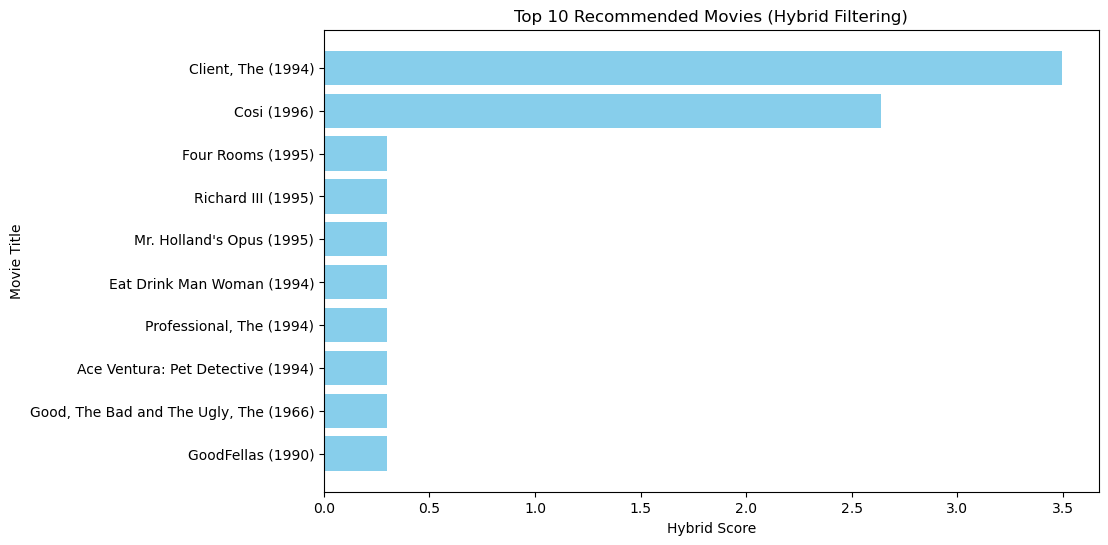

In [29]:
# Visualize the top recommended movies using a bar chart
top_recommended_titles = [item[1] for item in top_recommended]
top_recommended_scores = [item[2] for item in top_recommended]

plt.figure(figsize=(10, 6))
plt.barh(top_recommended_titles, top_recommended_scores, color='skyblue')
plt.xlabel('Hybrid Score')
plt.ylabel('Movie Title')
plt.title('Top 10 Recommended Movies (Hybrid Filtering)')
plt.gca().invert_yaxis()  # Invert y-axis to show highest score at the top
plt.show()

### 10 Least Recommended Movies

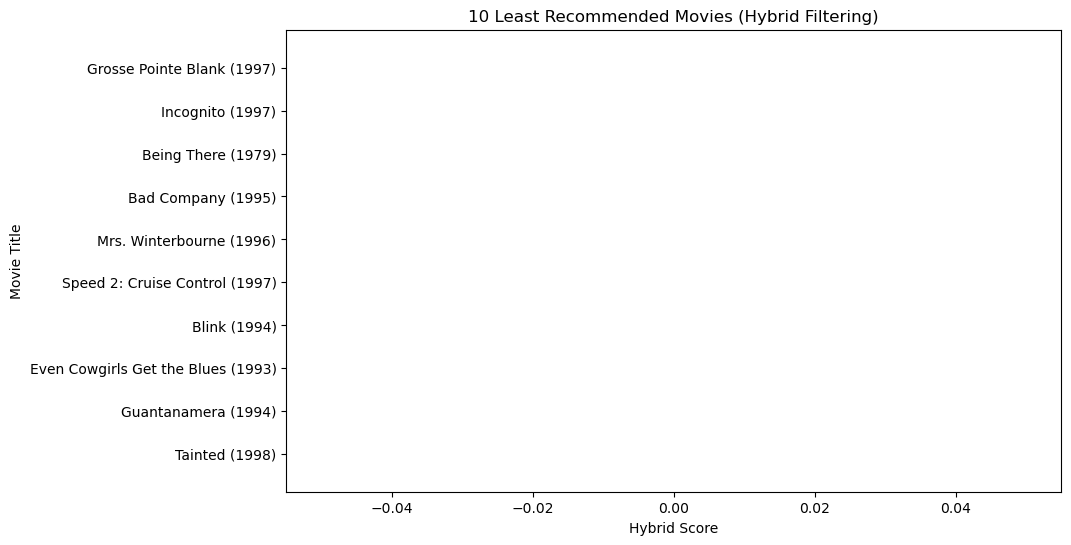

In [30]:
# Visualize the least recommended movies using a bar chart
least_recommended_titles = [item[1] for item in least_recommended]
least_recommended_scores = [item[2] for item in least_recommended]

plt.figure(figsize=(10, 6))
plt.barh(least_recommended_titles, least_recommended_scores, color='lightcoral')
plt.xlabel('Hybrid Score')
plt.ylabel('Movie Title')
plt.title('10 Least Recommended Movies (Hybrid Filtering)')
plt.gca().invert_yaxis()  # Invert y-axis to show lowest score at the top
plt.show()

# Conclusion:

In conclusion, our project stands as a testament to the power of data-driven personalization and emotion-aware recommendations. Through the intricate fusion of collaborative filtering and sentiment analysis, we've created a system that not only understands user preferences but also resonates with their emotions. 

As we wrap up this journey, we recognize the potential for further advancement in recommendation systems by incorporating real-time interactions, advanced sentiment analysis techniques, and more sophisticated machine learning models. 

We're excited about the possibilities our project opens up in the realm of personalized digital experiences, and we look forward to the continuous evolution of this technology.